In [1]:
import os
import argparse
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from transformer import Transformer, create_masks
from load_data import ALPHABET_SIZE, EXTRA_CHARS
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, LeaveOneOut, train_test_split
from sklearn.metrics import r2_score, confusion_matrix, mean_squared_error

# Load SMILES Strings

In [4]:
# This function standardizes a given SMILES string by converting it to a molecular object
# and then generating a canonical SMILES representation, including stereochemistry and Kekulé form.
from rdkit import Chem

def standardize_smiles(input_smiles):
   
    mol = Chem.MolFromSmiles(input_smiles)
    if mol is None:
        return None
    
  
    new_smiles = Chem.MolToSmiles(
        mol,
        canonical=True,
        isomericSmiles=True,
        kekuleSmiles=True
    )
    
    return new_smiles

In [2]:
#load the training dataset
import pandas as pd


df = pd.read_csv('Kp Database 2.csv')

data = df[['Smiles', 'ln(Kp25)2']]

# 打印数据预览
print(data)

                                         Smiles  ln(Kp25)2
0                                 C=CC(OCCCC)=O   9.689908
1               C=CC(OCCCCCCCCCCCCCCCCCCCCCC)=O  10.240106
2                         C=CC(OCC1=CC=CC=C1)=O   9.861859
3                    C=CC(OCCCCCCCCCCCCCCCCC)=O   9.999422
4                C=CC(OCCCCCCCCCCCCCCCCCCCCC)=O   9.744493
5                                C=CC(OCCOCC)=O  10.088893
6                       C=CC(OC[C@H](CC)CCCC)=O   9.649782
7      C=CC(O[C@H]1C[C@@H]2CC[C@@]1(C)C2(C)C)=O   9.193743
8                          C=CC(OCCCCCCC(C)C)=O   9.745668
9                                    C=CC(OC)=O   9.482556
10                    C=CC(OC[C@H](CCC)CCCCC)=O   9.546798
11                  C=CC(OCCCCCCCCCCCCCCCCCC)=O   9.908807
12                            C=CC(OC(C)(C)C)=O   9.689908
13                     C=CC(OCCOC(NCCCCCC)=O)=O  10.337122
14                C=C(OC(NCCCCCC)=O)C(OC(C)C)=O  10.014388
15                              CC(C(OCCO)=O)=C   7.1644

In [5]:
# standardized smiles of the training dataset
import numpy as np
smiles_list = df['Smiles'].tolist()

smiles_np = np.array(smiles_list)


standard_smiles_np = list(map(standardize_smiles, smiles_np))


print(smiles_list)
print(standard_smiles_np)

['C=CC(OCCCC)=O', 'C=CC(OCCCCCCCCCCCCCCCCCCCCCC)=O', 'C=CC(OCC1=CC=CC=C1)=O', 'C=CC(OCCCCCCCCCCCCCCCCC)=O', 'C=CC(OCCCCCCCCCCCCCCCCCCCCC)=O', 'C=CC(OCCOCC)=O', 'C=CC(OC[C@H](CC)CCCC)=O', 'C=CC(O[C@H]1C[C@@H]2CC[C@@]1(C)C2(C)C)=O', 'C=CC(OCCCCCCC(C)C)=O', 'C=CC(OC)=O', 'C=CC(OC[C@H](CCC)CCCCC)=O', 'C=CC(OCCCCCCCCCCCCCCCCCC)=O', 'C=CC(OC(C)(C)C)=O', 'C=CC(OCCOC(NCCCCCC)=O)=O', 'C=C(OC(NCCCCCC)=O)C(OC(C)C)=O', 'CC(C(OCCO)=O)=C', 'CC(C(OC[C@H](O)C)=O)=C', 'C=CC(OCCOC(NC1=CC=CC=C1)=O)=O', 'C=C(OC(NC1=CC=CC=C1)=O)C(OC(C)C)=O', 'CC(C(OCCCCCCCCCCCCCCCCCCCCCC)=O)=C', 'CC(C(OCCCC)=O)=C', 'CC(C(OCC1=CC=CC=C1)=O)=C', 'CC(C(OC1CCCCC1)=O)=C', 'CC(C(OCCCCCCCCCCCC)=O)=C', 'CC(C(OC[C@H](CC)CCCC)=O)=C', 'CC(C(OCC)=O)=C', 'CC(C(OC[C@@H]1CO1)=O)=C', 'CC(C(OCC(C)C)=O)=C', 'CC(C(O[C@H]1C[C@@H]2CC[C@@]1(C)C2(C)C)=O)=C', 'CC(C(OCCCCCCCC(C)C)=O)=C', 'CC(C(OC)=O)=C', 'CC(C(O[C@@H](CCC)CCCCCC)=O)=C', 'CC(C(OCCCCC)=O)=C', 'CC(C(OCCCCCCCCCCCCCCCCCC)=O)=C', 'C=CC=C', 'C=CC#N', 'CC(C(O)=O)=C', 'O=CNC=C', 'O=C1N(C=C)

In [6]:
smiles_strings = standard_smiles_np
print(smiles_strings)

['C=CC(=O)OCCCC', 'C=CC(=O)OCCCCCCCCCCCCCCCCCCCCCC', 'C=CC(=O)OCC1=CC=CC=C1', 'C=CC(=O)OCCCCCCCCCCCCCCCCC', 'C=CC(=O)OCCCCCCCCCCCCCCCCCCCCC', 'C=CC(=O)OCCOCC', 'C=CC(=O)OC[C@H](CC)CCCC', 'C=CC(=O)O[C@H]1C[C@@H]2CC[C@@]1(C)C2(C)C', 'C=CC(=O)OCCCCCCC(C)C', 'C=CC(=O)OC', 'C=CC(=O)OC[C@H](CCC)CCCCC', 'C=CC(=O)OCCCCCCCCCCCCCCCCCC', 'C=CC(=O)OC(C)(C)C', 'C=CC(=O)OCCOC(=O)NCCCCCC', 'C=C(OC(=O)NCCCCCC)C(=O)OC(C)C', 'C=C(C)C(=O)OCCO', 'C=C(C)C(=O)OC[C@@H](C)O', 'C=CC(=O)OCCOC(=O)NC1=CC=CC=C1', 'C=C(OC(=O)NC1=CC=CC=C1)C(=O)OC(C)C', 'C=C(C)C(=O)OCCCCCCCCCCCCCCCCCCCCCC', 'C=C(C)C(=O)OCCCC', 'C=C(C)C(=O)OCC1=CC=CC=C1', 'C=C(C)C(=O)OC1CCCCC1', 'C=C(C)C(=O)OCCCCCCCCCCCC', 'C=C(C)C(=O)OC[C@H](CC)CCCC', 'C=C(C)C(=O)OCC', 'C=C(C)C(=O)OC[C@@H]1CO1', 'C=C(C)C(=O)OCC(C)C', 'C=C(C)C(=O)O[C@H]1C[C@@H]2CC[C@@]1(C)C2(C)C', 'C=C(C)C(=O)OCCCCCCCC(C)C', 'C=C(C)C(=O)OC', 'C=C(C)C(=O)O[C@@H](CCC)CCCCCC', 'C=C(C)C(=O)OCCCCC', 'C=C(C)C(=O)OCCCCCCCCCCCCCCCCCC', 'C=CC=C', 'C=CC#N', 'C=C(C)C(=O)O', 'C=CNC=O', 'C=CN1CCCC

In [7]:
# load the test dataset
data_path2 = "smilestestEa.txt"
smiles_strings2 = [line.strip("\n") for line in open(data_path2, "r")]
print(len(smiles_strings2), "strings found")
print("first string:", smiles_strings2[0])

4 strings found
first string: CCCCCCCCCCCCOC(=O)C=C


In [8]:
smiles_np = np.array(smiles_strings2)


smiles_strings2 = list(map(standardize_smiles, smiles_np))


print(smiles_strings2)

['C=CC(=O)OCCCCCCCCCCCC', 'C=CC(=O)OCCCCCCCCCCCCC', 'C=C(C)C(=O)OC(C)(C)C', 'C=CC(=C)Cl']


# Set Paths

In [9]:
# load the pretrained Molecular Transformer model
checkpoint_path = "pretrained.ckpt"
max_length = 256
embedding_size = 512
num_layers = 6

# Create Transformer w/ Pretrained Weights

In [10]:
model = Transformer(ALPHABET_SIZE, embedding_size, num_layers).eval()
model = torch.nn.DataParallel(model)

In [11]:
checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
model.load_state_dict(checkpoint['state_dict'])
model = model.module.cpu() #unwrap from nn.DataParallel
encoder = model.encoder.cpu()

# Generate Embedding Matrices

In [12]:
def encode_char(c):
    return ord(c) - 32

def encode_smiles(string, start_char=EXTRA_CHARS['seq_start']):
    encoded_chars = [ord(start_char)]  
    
    
    for c in string:
        encoded_chars.append(encode_char(c))
        
   
    encoded_tensor = torch.tensor(encoded_chars, dtype=torch.long)[:max_length].unsqueeze(0)
    return encoded_tensor

In [13]:
#generate embedding matrices for the training dataset
embeddings = []
with torch.no_grad():
    for smiles in smiles_strings:
        encoded = encode_smiles(smiles)
        mask = create_masks(encoded)
        embedding = encoder(encoded, mask)[0].numpy()
        embeddings.append(embedding)
        print(embedding.sum())
        print("embedded {0} into {1} matrix.".format(smiles, str(embedding.shape)))

-11.252537
embedded C=CC(=O)OCCCC into (14, 512) matrix.
-83.92625
embedded C=CC(=O)OCCCCCCCCCCCCCCCCCCCCCC into (32, 512) matrix.
-34.136627
embedded C=CC(=O)OCC1=CC=CC=C1 into (22, 512) matrix.
-76.864235
embedded C=CC(=O)OCCCCCCCCCCCCCCCCC into (27, 512) matrix.
-80.92773
embedded C=CC(=O)OCCCCCCCCCCCCCCCCCCCCC into (31, 512) matrix.
-8.873117
embedded C=CC(=O)OCCOCC into (15, 512) matrix.
-9.700385
embedded C=CC(=O)OC[C@H](CC)CCCC into (24, 512) matrix.
-52.350945
embedded C=CC(=O)O[C@H]1C[C@@H]2CC[C@@]1(C)C2(C)C into (41, 512) matrix.
10.861363
embedded C=CC(=O)OCCCCCCC(C)C into (21, 512) matrix.
6.896442
embedded C=CC(=O)OC into (11, 512) matrix.
-38.39682
embedded C=CC(=O)OC[C@H](CCC)CCCCC into (26, 512) matrix.
-78.964264
embedded C=CC(=O)OCCCCCCCCCCCCCCCCCC into (28, 512) matrix.
-21.361935
embedded C=CC(=O)OC(C)(C)C into (18, 512) matrix.
-57.75853
embedded C=CC(=O)OCCOC(=O)NCCCCCC into (25, 512) matrix.
-78.543564
embedded C=C(OC(=O)NCCCCCC)C(=O)OC(C)C into (30, 512) matrix.

In [14]:
#generate embedding matrices for the test dataset
embeddings_test = []
with torch.no_grad():
    for smiles in smiles_strings2:
        encoded = encode_smiles(smiles)
        mask = create_masks(encoded)
        embedding = encoder(encoded, mask)[0].numpy()
        embeddings_test.append(embedding)
        print(embedding.sum())
        print("embedded {0} into {1} matrix.".format(smiles, str(embedding.shape)))

-45.796276
embedded C=CC(=O)OCCCCCCCCCCCC into (22, 512) matrix.
-51.193123
embedded C=CC(=O)OCCCCCCCCCCCCC into (23, 512) matrix.
-3.5738645
embedded C=C(C)C(=O)OC(C)(C)C into (21, 512) matrix.
1.804668
embedded C=CC(=C)Cl into (11, 512) matrix.


In [15]:
# This code calculates the mean of each embedding matrix along the specified axis
# and then stacks these mean vectors into a single matrix for further analysis.
import numpy as np


mean_matrices = [matrix.mean(axis=0) for matrix in embeddings_test]


stacked_matrixtest = np.stack(mean_matrices)
print(stacked_matrixtest)

[[-0.9033428   0.53249323  0.49870336 ...  0.730994   -0.5839008
   0.05508909]
 [-1.0058737   0.54915357  0.48136577 ...  0.613144   -0.5792535
   0.0357954 ]
 [-0.2574998   0.05508881  0.8198613  ...  0.36202163 -0.7582939
   0.8511645 ]
 [-0.00579173 -0.17221923  0.41350213 ...  0.13205248 -0.2425478
   0.3758541 ]]


In [16]:
import numpy as np


mean_matrices = [matrix.mean(axis=0) for matrix in embeddings]


stacked_matrix = np.stack(mean_matrices)
print(stacked_matrix)

[[-0.17750224  0.37065738  0.97206825 ...  0.75600415 -0.84649074
   0.88909763]
 [-0.97046804  0.52409333  0.09709945 ...  0.5574631  -0.2976708
   0.09868877]
 [-0.63346493  0.40803006  0.1918938  ...  0.66276956 -0.45967495
   0.2747269 ]
 ...
 [-0.03203479  0.36170673  0.20542699 ...  0.6716949  -0.16572212
   0.05306133]
 [-1.0764668   0.0374366   0.12736042 ...  0.28881067 -0.3279695
  -0.06811953]
 [ 0.22044411  0.04125086  0.4181036  ...  0.6260119  -0.10209955
   0.28543252]]


In [17]:
# This code converts a list of SMILES strings into MACCS fingerprints.
# Each fingerprint is generated from the corresponding molecule and stored in a list for further analysis.
from rdkit import Chem
from rdkit.Chem import MACCSkeys
smiles = smiles_strings
def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    maccs_fp = MACCSkeys.GenMACCSKeys(mol)
    return np.array(list(maccs_fp.ToBitString()), dtype=int)
fingerprints = []
for smi in smiles:
    fingerprint = smiles_to_maccs(smi)
    fingerprints.append(fingerprint)
X_train_Maccs = fingerprints
print(X_train_Maccs)

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
  

In [18]:

from rdkit import Chem
from rdkit.Chem import MACCSkeys
smiles = smiles_strings2
def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    maccs_fp = MACCSkeys.GenMACCSKeys(mol)
    return np.array(list(maccs_fp.ToBitString()), dtype=int)
fingerprints = []
for smi in smiles:
    fingerprint = smiles_to_maccs(smi)
    fingerprints.append(fingerprint)
X_test_Maccs = fingerprints
print(X_test_Maccs)

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
  

In [19]:
# Stack the MACCS fingerprints and Molecular Transformer embeddings together.
import numpy as np


X_test = np.hstack((X_test_Maccs, stacked_matrixtest))


print(X_test)

[[ 0.          0.          0.         ...  0.73099399 -0.58390081
   0.05508909]
 [ 0.          0.          0.         ...  0.61314398 -0.57925349
   0.0357954 ]
 [ 0.          0.          0.         ...  0.36202163 -0.75829393
   0.85116452]
 [ 0.          0.          0.         ...  0.13205248 -0.2425478
   0.3758541 ]]


In [20]:
#Stack the MACCS fingerprints and Molecular Transformer embeddings together.
import numpy as np


X_train = np.hstack((X_train_Maccs, stacked_matrix))


print(X_train)

[[ 0.          0.          0.         ...  0.75600415 -0.84649074
   0.88909763]
 [ 0.          0.          0.         ...  0.55746311 -0.29767081
   0.09868877]
 [ 0.          0.          0.         ...  0.66276956 -0.45967495
   0.2747269 ]
 ...
 [ 0.          0.          0.         ...  0.67169487 -0.16572212
   0.05306133]
 [ 0.          0.          0.         ...  0.28881067 -0.32796949
  -0.06811953]
 [ 0.          0.          0.         ...  0.62601191 -0.10209955
   0.28543252]]


In [21]:
#Select the parameters for y
data = df[['ln(Kp25)2',]]
y_train = data['ln(Kp25)2']
print(y_train)



0      9.689908
1     10.240106
2      9.861859
3      9.999422
4      9.744493
5     10.088893
6      9.649782
7      9.193743
8      9.745668
9      9.482556
10     9.546798
11     9.908807
12     9.689908
13    10.337122
14    10.014388
15     7.164460
16     6.680034
17    10.531541
18     9.676212
19     6.457658
20     5.912740
21     6.488386
22     6.378967
23     6.264769
24     5.972977
25     5.780109
26     6.189050
27     5.991779
28     6.315599
29     5.972977
30     5.778290
31     6.093550
32     6.005924
33     6.384434
34     3.801749
35     8.185090
36     6.352898
37     7.805159
38     9.961846
39     4.453608
40     8.188475
Name: ln(Kp25)2, dtype: float64


In [22]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import LeaveOneOut, cross_validate
res = cross_validate(BayesianRidge(), X_train, y_train, cv=LeaveOneOut(), 
                     scoring='neg_mean_squared_error', return_train_score=True, return_estimator=True)

sum = np.zeros(len(res["estimator"]))
for est in res["estimator"]:
    sum += est.predict(X_train)
ans = sum / len(res["estimator"])
print(ans)

[ 9.71705897  9.958531    9.77973521  9.94062426  9.95275083 10.07525374
  9.52486932  9.04958338  9.72443478  9.52869071  9.58340236  9.90837686
  9.74549836 10.3908284   9.94746637  7.10739089  6.70327432 10.53869599
  9.6629063   6.56117532  5.92504481  6.55023099  6.38659794  6.26027842
  6.04221727  5.83524009  6.21024531  5.9297138   6.45754697  5.99934489
  5.70710565  6.09499023  5.99317944  6.43760148  3.85290928  8.15280371
  6.30940615  7.84936568  9.92039514  4.54777036  8.2260937 ]


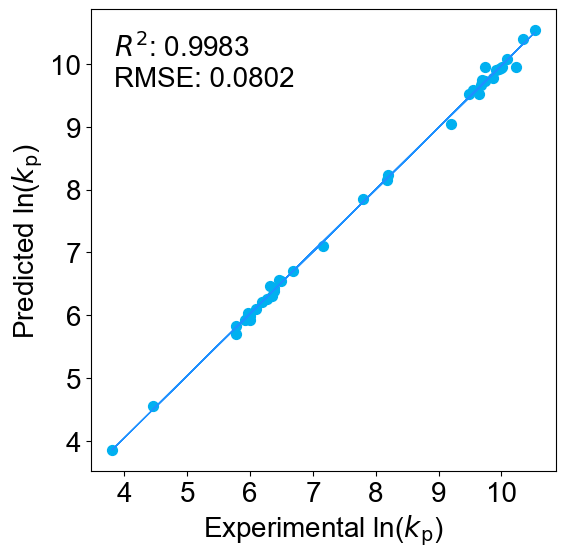

In [23]:
#Calculate R² and RMSE, and create plots.
plt.rcParams['font.family'] = 'Arial'


r2 = r2_score(y_train,ans)
rmse = np.sqrt(mean_squared_error(y_train,ans))

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_train, ans, c='#00B0F0', s=50)
ax.plot(y_train, np.polyval(np.polyfit(y_train, ans, 1), y_train), color='#1E90FF', lw=1)
ax.set_xlabel(r"Experimental ln($k\mathrm{_p}$)",fontsize=20)
ax.set_ylabel(r"Predicted ln($k\mathrm{_p}$)",fontsize=20)
ax.text(0.05, 0.95, f'$R^2$: {r2:.4f}\nRMSE: {rmse:.4f}', transform=ax.transAxes, va='top', fontsize=20)
ax.set_xticks([4, 5, 6, 7, 8, 9, 10])  
ax.set_yticks([4, 5, 6, 7, 8, 9,10])  
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

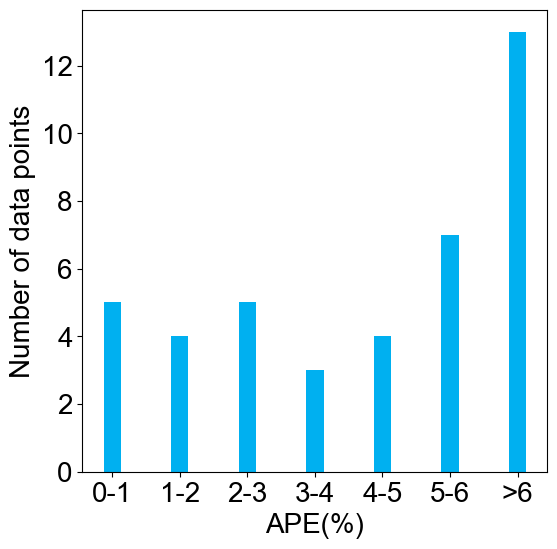

In [24]:
#Calculate the distribution of APE，here the meaning of are same to APE
true = np.exp(y_train)
pred = np.exp(ans)
plt.rcParams['font.family'] = 'Arial'

are = np.abs((pred - true) / true) * 100
are_bins = [0, 1, 2, 3, 4, 5, 6, np.inf]
are_counts, _ = np.histogram(are, bins=are_bins)


fig, ax = plt.subplots(figsize=(6, 6))
x = np.arange(len(are_bins) - 1)
bar_width = 1.8 / (len(are_bins) - 1)
ax.bar(x, are_counts, width=bar_width, color='#00B0F0')
ax.set_xticks(x)
ax.set_xticklabels([f'{are_bins[i]:.0f}-{are_bins[i+1]:.0f}' for i in range(len(are_bins) - 2)] + [f'>{are_bins[-2]:.0f}'])
ax.set_xlabel("APE(%)",fontsize = 20)
ax.set_ylabel("Number of data points",fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [25]:
#Predict Kp for the test dataset
sum = np.zeros(len(X_test))

for est in res["estimator"]:
    sum = sum + est.predict(X_test)

Y_test = sum / len(res["estimator"])
Y_origin_linear = np.exp(Y_test)
Y_origin_linear = np.round(Y_origin_linear).astype(int)
print(Y_origin_linear)

[18837 22151   260    75]


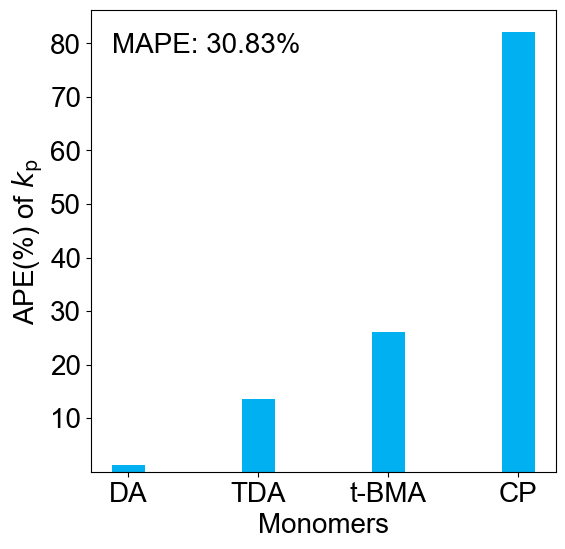

In [26]:
# calculate the mean absolute percentage error
plt.rcParams['font.family'] = 'Arial'

y_true = [ 18588,19489,352,421]
y_pred = [ 18837,22151,260,75]

labels = [ 'DA', 'TDA','t-BMA','CP']

# Calculate ARE for each monomer
are = [(abs(y_p - y_t) / y_t) * 100 for y_t, y_p in zip(y_true, y_pred)]

# Calculate MARE (Mean Absolute Relative Error)
mare = np.mean(are)

fig, ax = plt.subplots(figsize=(6, 6))
ax.bar(labels, are, width=0.25, color='#00B0F0')
ax.set_xlabel('Monomers',fontsize = 20)
ax.set_ylabel('APE(%) of $k\mathrm{_p}$',fontsize = 20)
ax.text(0.45, 0.95, f"MAPE: {mare:.2f}%", transform=ax.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='right')
ax.set_yticks([10, 20, 30, 40, 50, 60,70,80])
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [27]:
# test the multivariate linear regression
res = cross_validate(LinearRegression(), X_train, y_train, cv=LeaveOneOut(), scoring='neg_mean_squared_error', return_train_score=True, return_estimator=True)

sum = np.zeros(len(res["estimator"]))

for est in res["estimator"]:
    sum = sum + est.predict(X_train)

ans = sum / len(res["estimator"])
print(ans)

[ 9.67590257 10.22697432  9.86371831 10.01033746  9.7547144  10.10292226
  9.6362749   9.18577616  9.74104487  9.50361865  9.56040204  9.8994765
  9.6858004  10.37951556  9.99044618  7.12436676  6.69000523 10.50099793
  9.67821202  6.50718877  5.9320401   6.4861586   6.42923375  6.22156894
  5.97684925  5.80246396  6.19955623  5.97790932  6.32483061  5.98347607
  5.75576013  6.09378285  5.98627784  6.34473811  3.84442191  8.13233482
  6.35361273  7.89086507  9.83645302  4.57022754  8.18877851]


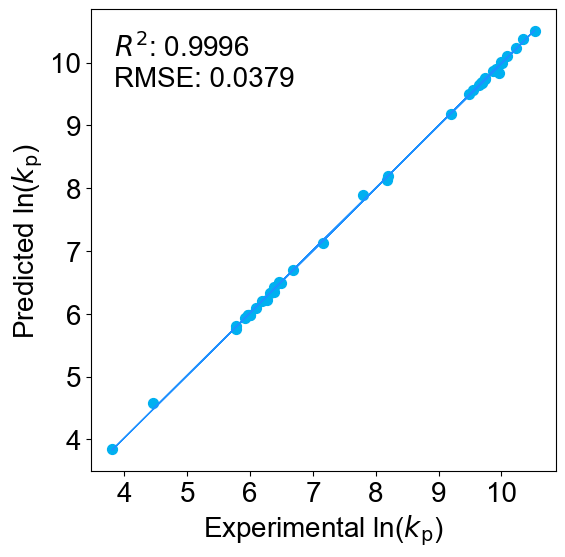

In [28]:

plt.rcParams['font.family'] = 'Arial'

r2 = r2_score(y_train,ans)
rmse = np.sqrt(mean_squared_error(y_train,ans))

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_train, ans, c='#00B0F0', s=50)
ax.plot(y_train, np.polyval(np.polyfit(y_train, ans, 1), y_train), color='#1E90FF', lw=1)
ax.set_xlabel(r"Experimental ln($k\mathrm{_p}$)",fontsize=20)
ax.set_ylabel(r"Predicted ln($k\mathrm{_p}$)",fontsize=20)
ax.text(0.05, 0.95, f'$R^2$: {r2:.4f}\nRMSE: {rmse:.4f}', transform=ax.transAxes, va='top', fontsize=20)
ax.set_xticks([4, 5, 6, 7, 8, 9, 10])  
ax.set_yticks([4, 5, 6, 7, 8, 9,10])  
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

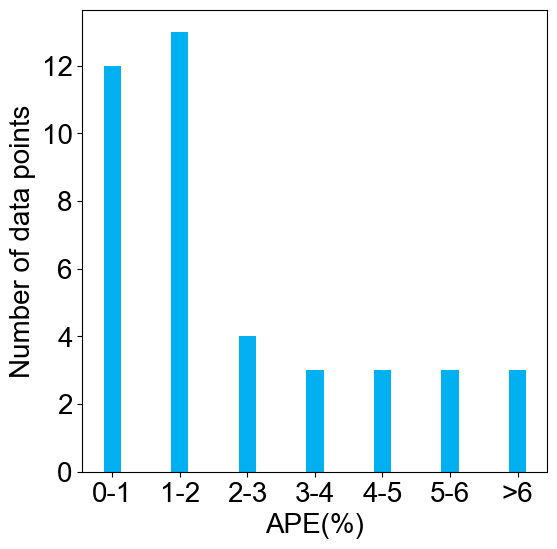

In [29]:

true = np.exp(y_train)
pred = np.exp(ans)

plt.rcParams['font.family'] = 'Arial'

are = np.abs((pred - true) / true) * 100
are_bins = [0, 1, 2, 3, 4, 5, 6, np.inf]
are_counts, _ = np.histogram(are, bins=are_bins)


fig, ax = plt.subplots(figsize=(6, 6))
x = np.arange(len(are_bins) - 1)
bar_width = 1.8 / (len(are_bins) - 1)
ax.bar(x, are_counts, width=bar_width, color='#00B0F0')
ax.set_xticks(x)
ax.set_xticklabels([f'{are_bins[i]:.0f}-{are_bins[i+1]:.0f}' for i in range(len(are_bins) - 2)] + [f'>{are_bins[-2]:.0f}'])
ax.set_xlabel("APE(%)",fontsize = 20)
ax.set_ylabel("Number of data points",fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [30]:
sum = np.zeros(len(X_test))

for est in res["estimator"]:
    sum = sum + est.predict(X_test)

Y_test = sum / len(res["estimator"])
Y_origin_linear = np.exp(Y_test)
Y_origin_linear = np.round(Y_origin_linear).astype(int)
print(Y_origin_linear)

[20233 22838   318   376]


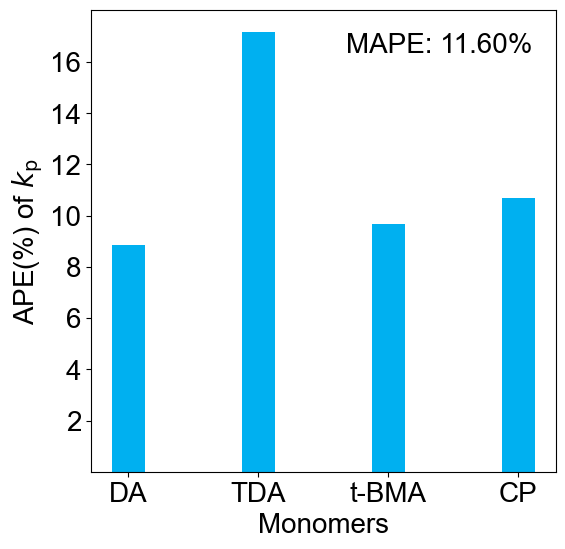

In [32]:

plt.rcParams['font.family'] = 'Arial'

y_true = [18588,19489,352,421]
y_pred = [20233,22838,318,376]
labels = [ 'DA', 'TDA','t-BMA','CP']


are = [(abs(y_p - y_t) / y_t) * 100 for y_t, y_p in zip(y_true, y_pred)]


mare = np.mean(are)

fig, ax = plt.subplots(figsize=(6, 6))
ax.bar(labels, are, width=0.25, color='#00B0F0')
ax.set_xlabel('Monomers',fontsize = 20)
ax.set_ylabel('APE(%) of $k\mathrm{_p}$',fontsize = 20)
ax.text(0.95, 0.95, f"MAPE: {mare:.2f}%", transform=ax.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='right')
ax.set_yticks([2, 4, 6, 8, 10, 12,14,16])
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [33]:
# test the RidgeCV model
res = cross_validate(RidgeCV(alphas=(10**np.linspace(10,-2,300)*0.5)), X_train, y_train, cv=LeaveOneOut(), scoring='neg_mean_squared_error', return_train_score=True, return_estimator=True,)

sum = np.zeros(len(res["estimator"]))

for est in res["estimator"]:
    sum = sum + est.predict(X_train)

ans = sum / len(res["estimator"])
print(ans)

[ 9.72456885  9.94075473  9.75887953  9.93177088  9.94094517 10.07193692
  9.49653672  9.01522399  9.71548961  9.53522587  9.58499242  9.90391954
  9.7530812  10.39940627  9.93355109  7.09638179  6.70737466 10.54245215
  9.6579966   6.58108789  5.92924162  6.56470243  6.38650151  6.26070461
  6.06032305  5.84615686  6.21521588  5.91607041  6.48941889  6.00717537
  5.69330129  6.098931    5.99445504  6.46442848  3.8615725   8.14868067
  6.30107859  7.85371355  9.91745692  4.55952073  8.23044494]


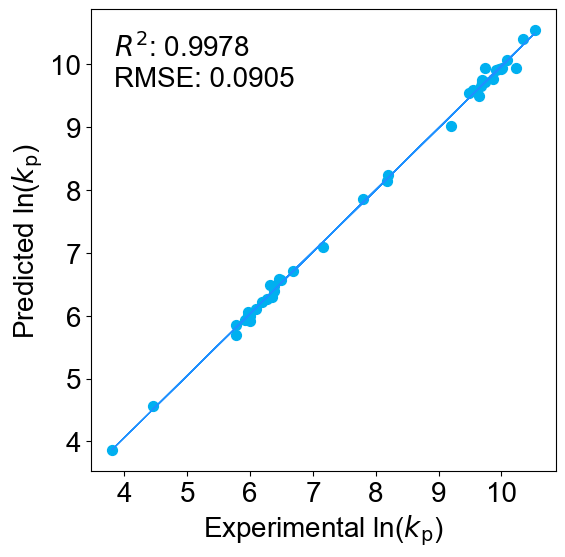

In [34]:

plt.rcParams['font.family'] = 'Arial'
r2 = r2_score(y_train,ans)
rmse = np.sqrt(mean_squared_error(y_train,ans))

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_train, ans, c='#00B0F0', s=50)
ax.plot(y_train, np.polyval(np.polyfit(y_train, ans, 1), y_train), color='#1E90FF', lw=1)
ax.set_xlabel(r"Experimental ln($k\mathrm{_p}$)",fontsize=20)
ax.set_ylabel(r"Predicted ln($k\mathrm{_p}$)",fontsize=20)
ax.text(0.05, 0.95, f'$R^2$: {r2:.4f}\nRMSE: {rmse:.4f}', transform=ax.transAxes, va='top', fontsize=20)
ax.set_xticks([4, 5, 6, 7, 8, 9, 10])  
ax.set_yticks([4, 5, 6, 7, 8, 9,10])  
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

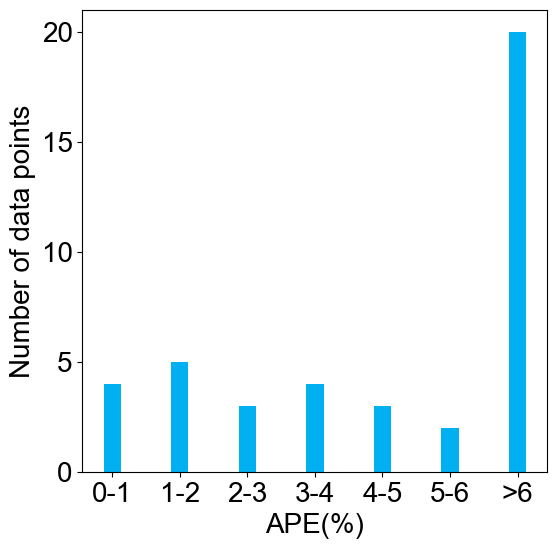

In [36]:

true = np.exp(y_train)
pred = np.exp(ans)
plt.rcParams['font.family'] = 'Arial'
are = np.abs((pred - true) / true) * 100
are_bins = [0, 1, 2, 3, 4, 5, 6, np.inf]
are_counts, _ = np.histogram(are, bins=are_bins)
fig, ax = plt.subplots(figsize=(6, 6))
x = np.arange(len(are_bins) - 1)
bar_width = 1.8 / (len(are_bins) - 1)
ax.bar(x, are_counts, width=bar_width, color='#00B0F0')
ax.set_xticks(x)
ax.set_xticklabels([f'{are_bins[i]:.0f}-{are_bins[i+1]:.0f}' for i in range(len(are_bins) - 2)] + [f'>{are_bins[-2]:.0f}'])
ax.set_xlabel("APE(%)",fontsize = 20)
ax.set_ylabel("Number of data points",fontsize = 20) 
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [37]:
sum = np.zeros(len(X_test))

for est in res["estimator"]:
    sum = sum + est.predict(X_test)

Y_test = sum / len(res["estimator"])
Y_origin_ridge = np.exp(Y_test)
Y_origin_ridge = np.round(Y_origin_ridge).astype(int)
print(Y_origin_ridge)


[18355 21521   260    75]


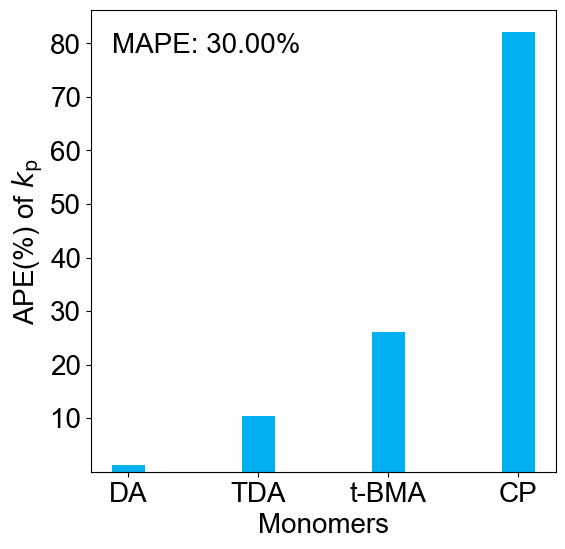

In [38]:

y_true = [18588,19489,352,421]
y_pred = [18355,21521,260,75]
labels = [ 'DA', 'TDA','t-BMA','CP']

plt.rcParams['font.family'] = 'Arial'



are = [(abs(y_p - y_t) / y_t) * 100 for y_t, y_p in zip(y_true, y_pred)]


mare = np.mean(are)

fig, ax = plt.subplots(figsize=(6, 6))
ax.bar(labels, are, width=0.25, color='#00B0F0')
ax.set_xlabel('Monomers',fontsize = 20)
ax.set_ylabel('APE(%) of $k\mathrm{_p}$',fontsize = 20)
ax.text(0.45, 0.95, f"MAPE: {mare:.2f}%", transform=ax.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='right')
ax.set_yticks([10, 20, 30, 40, 50, 60,70,80])
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [39]:
# test the lasso regression model
res = cross_validate(LassoCV(alphas=(10**np.linspace(10,-4,500)*0.5)), X_train, y_train, cv=LeaveOneOut(), scoring='neg_mean_squared_error', return_train_score=True, return_estimator=True,)

sum = np.zeros(len(res["estimator"]))

for est in res["estimator"]:
    sum = sum + est.predict(X_train)

ans = sum / len(res["estimator"])
print(ans)

F:\ana\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.272e-02, tolerance: 1.177e-02
  model = cd_fast.enet_coordinate_descent(
F:\ana\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.212e-02, tolerance: 1.177e-02
  model = cd_fast.enet_coordinate_descent(
F:\ana\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.233e-02, tolerance: 1.213e-02
  model = cd_fast.enet_coordinate_descent

[ 9.61335591  9.99674672  9.84578545  9.9522787   9.96303034 10.1198175
  9.51190557  9.26238072  9.69306405  9.50115891  9.60982283  9.9163742
  9.74106482 10.35816523  9.98199074  7.13260786  6.6656141  10.50937875
  9.70931993  6.50350649  5.97675888  6.4724027   6.40407678  6.28359336
  6.02832453  5.81675302  6.21737269  5.98383132  6.2559333   5.99102502
  5.70573032  6.06865115  6.01112135  6.40822079  3.91915014  8.09940055
  6.29597836  7.85984942  9.88333904  4.55292307  8.19255879]


F:\ana\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.820e-02, tolerance: 1.512e-02
  model = cd_fast.enet_coordinate_descent(


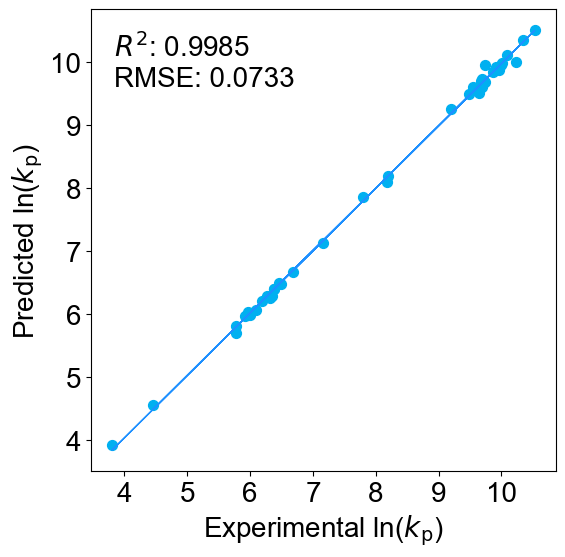

In [40]:




r2 = r2_score(y_train,ans)
rmse = np.sqrt(mean_squared_error(y_train,ans))
plt.rcParams['font.family'] = 'Arial'

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_train, ans, c='#00B0F0', s=50)
ax.plot(y_train, np.polyval(np.polyfit(y_train, ans, 1), y_train), color='#1E90FF', lw=1)
ax.set_xlabel(r"Experimental ln($k\mathrm{_p}$)",fontsize=20)
ax.set_ylabel(r"Predicted ln($k\mathrm{_p}$)",fontsize=20)
ax.text(0.05, 0.95, f'$R^2$: {r2:.4f}\nRMSE: {rmse:.4f}', transform=ax.transAxes, va='top', fontsize=20)
ax.set_xticks([4, 5, 6, 7, 8, 9, 10])  
ax.set_yticks([4, 5, 6, 7, 8, 9,10])  
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

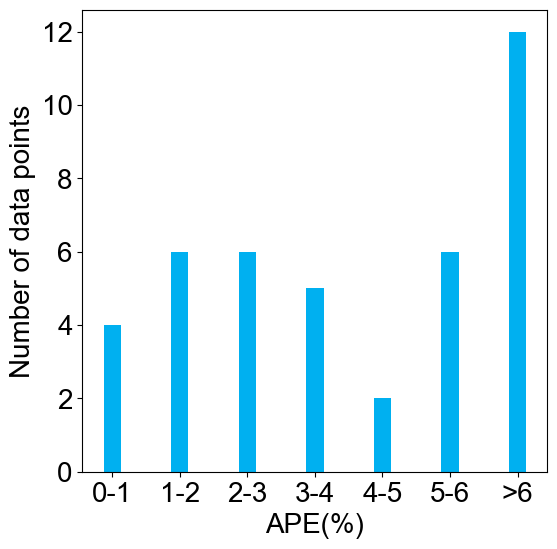

In [41]:

true = np.exp(y_train)
pred = np.exp(ans)


plt.rcParams['font.family'] = 'Arial'

are = np.abs((pred - true) / true) * 100
are_bins = [0, 1, 2, 3, 4, 5, 6, np.inf]
are_counts, _ = np.histogram(are, bins=are_bins)


fig, ax = plt.subplots(figsize=(6, 6))
x = np.arange(len(are_bins) - 1)
bar_width = 1.8 / (len(are_bins) - 1)
ax.bar(x, are_counts, width=bar_width, color='#00B0F0')
ax.set_xticks(x)
ax.set_xticklabels([f'{are_bins[i]:.0f}-{are_bins[i+1]:.0f}' for i in range(len(are_bins) - 2)] + [f'>{are_bins[-2]:.0f}'])
ax.set_xlabel("APE(%)",fontsize = 20)
ax.set_ylabel("Number of data points",fontsize = 20) 
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [42]:
sum = np.zeros(len(X_test))

for est in res["estimator"]:
    sum = sum + est.predict(X_test)

Y_test = sum / len(res["estimator"])
Y_origin_lasso_avg = np.exp(Y_test)
Y_origin_lasso_avg = np.round(Y_origin_lasso_avg).astype(int)
print(Y_origin_lasso_avg)

[17682 20333   381   440]


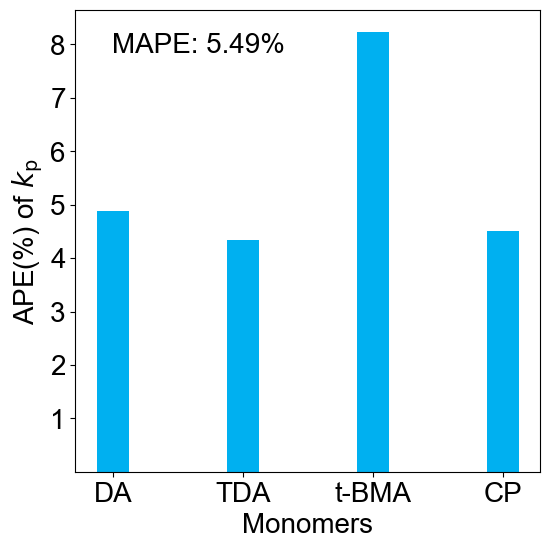

In [43]:


y_true = [18588,19489,352,421]
y_pred = [17682,20333,381,440]
labels = [ 'DA', 'TDA','t-BMA','CP']

plt.rcParams['font.family'] = 'Arial'




are = [(abs(y_p - y_t) / y_t) * 100 for y_t, y_p in zip(y_true, y_pred)]

mare = np.mean(are)

fig, ax = plt.subplots(figsize=(6, 6))
ax.bar(labels, are, width=0.25, color='#00B0F0')
ax.set_xlabel('Monomers',fontsize = 20)
ax.set_ylabel('APE(%) of $k\mathrm{_p}$',fontsize = 20)
ax.text(0.45, 0.95, f"MAPE: {mare:.2f}%", transform=ax.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='right')
ax.set_yticks([1,2,3,4, 5, 6, 7, 8])
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()